## Recreating the Master Unit List

#### setup/imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa
import logging
import sys
import copy
import pathlib

from copy import deepcopy

In [3]:
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.style.use('dark_background')

In [4]:
from rmi_pudl.make_plant_parts_eia import *
pd.options.display.max_columns = None

In [5]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

#### defining a table grabbing objectDEBUG

In [7]:
pudl_settings = pudl.workspace.setup.get_defaults()
#pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
pudl_engine = sa.create_engine('sqlite:////Users/christinagosnell/code/pudl_work/sqlite/pudl_wo_ytd.sqlite')

In [9]:
table_compiler = CompileTables(pudl_engine=pudl_engine, freq='AS',)

In [10]:
parts_compiler = CompilePlantParts(table_compiler,clobber=True)

In [11]:
plant_parts_df = parts_compiler.generate_master_unit_list(qual_records=True, clobber=True)

Generating the master generator table with ownership.
beginning the aggregation for generation_eia923
getting generation_eia923 from the sqlite db
beginning the aggregation for generators_eia860
getting generators_eia860 from the sqlite db
beginning the aggregation for mcoe
getting mcoe from the output object
filling in fuel cost NaNs EIA APIs monthly state averages
filling in fuel cost NaNs with rolling averages
getting ownership_eia860 from the sqlite db
getting boiler_generator_assn_eia860 from the sqlite db
getting generators_entity_eia from the sqlite db


FileNotFoundError: [Errno 2] No such file or directory: '/Users/christinagosnell/code/rmi-ferc1-eia/depreciation_rmi.xlsx'

In [11]:
parts_compiler.test_run_aggregations()

Begining tests for plant:
  Results for total_fuel_cost: [True, False]
  Results for net_generation_mwh: [True, False]
  Results for capacity_mw: [True, False]
  Results for total_mmbtu: [True, False]
Begining tests for plant_unit:
  Results for capacity_mw: [True, False]
  Results for net_generation_mwh: [True, False]
  Results for total_fuel_cost: [True, False]
  Results for total_mmbtu: [True, False]
Begining tests for plant_prime_mover:
  Results for capacity_mw: [True, False]
  Results for net_generation_mwh: [True, False]
  Results for total_fuel_cost: [True, False]
  Results for total_mmbtu: [True, False]
Begining tests for plant_technology:
  Results for capacity_mw: [True, False]
  Results for net_generation_mwh: [True, False]
  Results for total_fuel_cost: [True, False]
  Results for total_mmbtu: [True, False]
Begining tests for plant_prime_fuel:
  Results for capacity_mw: [True, False]
  Results for net_generation_mwh: [True, False]
  Results for total_fuel_cost: [True, Fals

In [19]:
file_path_mul = pathlib.Path().cwd().parent /'outputs' /'master_unit_list.pkl.gz'
file_path_mul_csv = pathlib.Path().cwd().parent / 'outputs'/'master_unit_list.csv.gz'
plant_parts_df.to_csv(file_path_mul_csv)
plant_parts_df.to_pickle(file_path_mul)

In [13]:
compiled_plant_parts = {}
compiled_plant_parts_true = {}
true_parts_df = plant_parts_df[plant_parts_df.true_gran]
for part in parts_compiler.plant_parts.keys():
    part_df = plant_parts_df[(plant_parts_df['plant_part'] == part)]
    compiled_plant_parts_true[part] = true_parts_df[(true_parts_df['plant_part'] == part)]
    compiled_plant_parts[part] = part_df

In [14]:
def plot_plant_vs_agg(compiled_plant_parts, field, xy_limits, scale):
    """
    Make plots to compare FERC & EIA reported values for Coal & Gas plants.
    
    For each of the fields specified in fields_to_plot, create a pair of plots,
    one for 'gas' and one for 'coal' in the same frame, showing the EIA quantity
    vs. the FERC quantity in a scatter plot.
    """
    for plant_gran, df in compiled_plant_parts.items():
        if plant_gran != 'plant':
            field_plant = field+'_plant'
            field_gran = field+'_'+plant_gran
            try:
                merge_df = compiled_plant_parts['plant'].merge(df, on=['plant_id_eia', 
                                                                       'report_date',
                                                                       'utility_id_eia',
                                                                       'ownership'
                                                                      ], suffixes=('_plant','_' + plant_gran))
                # this is for the try
                merge_df[field_gran]
                #merge_df = merge_df[merge_df['plant_id_eia'] == 3]
                fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
                ax.scatter(merge_df[field_plant],
                           merge_df[field_gran],
                           color='aquamarine', alpha=0.1, label=field)
                ax.set_ylim(xy_limits[field][0],xy_limits[field][1])
                ax.set_xlim(xy_limits[field][0],xy_limits[field][1])
                ax.set_xscale(scale)
                ax.set_yscale(scale)
                ax.set_ylabel(f'{plant_gran} {field}')
                ax.set_xlabel(f'Plant {field}')
                ax.set_title(f"Plant vs {plant_gran}: {field}")
            except KeyError:
                pass

<ipython-input-14-1600d134e24a>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))


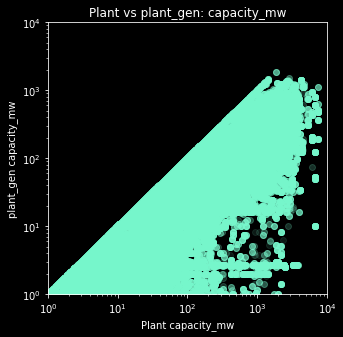

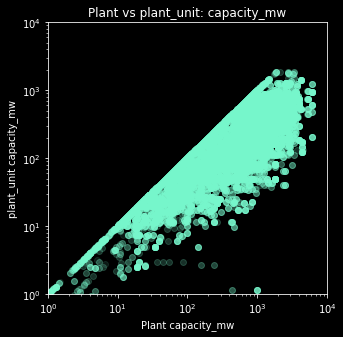

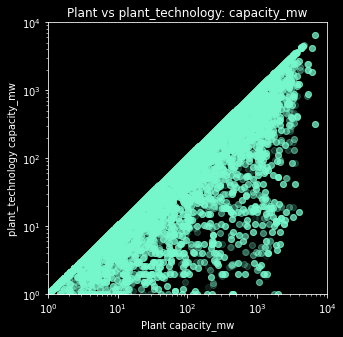

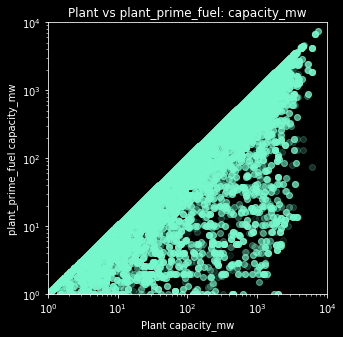

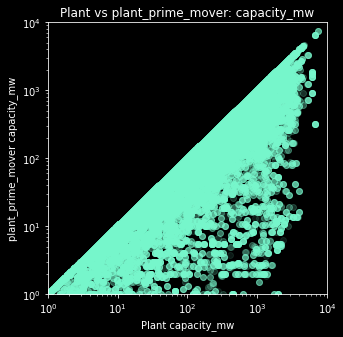

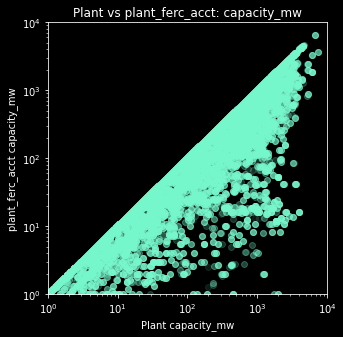

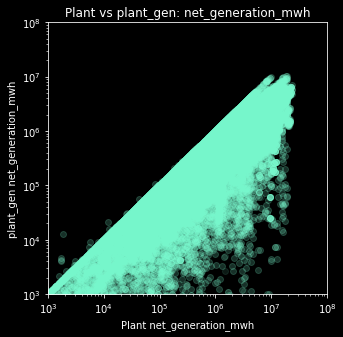

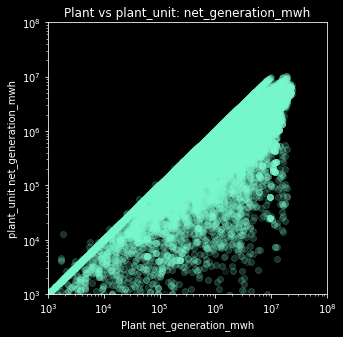

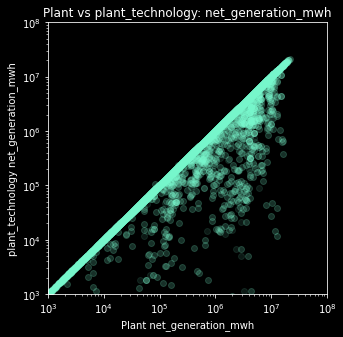

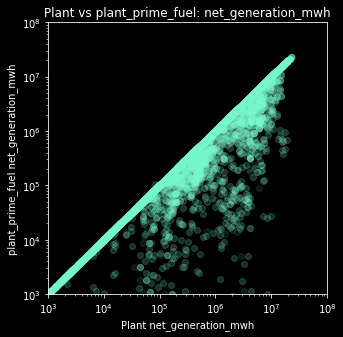

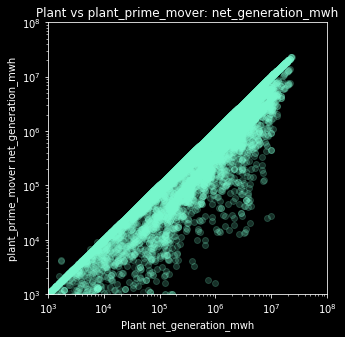

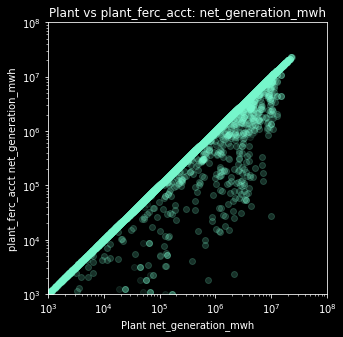

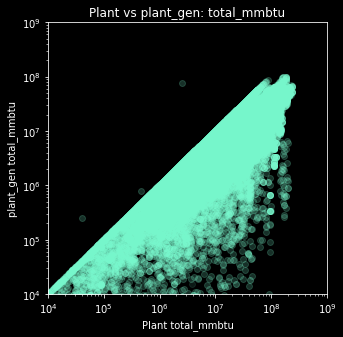

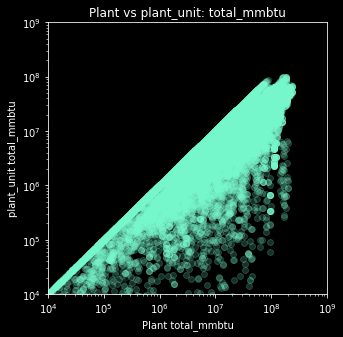

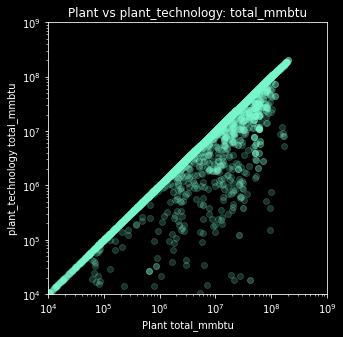

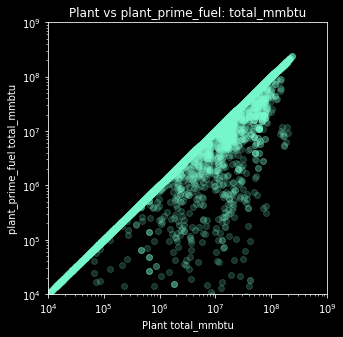

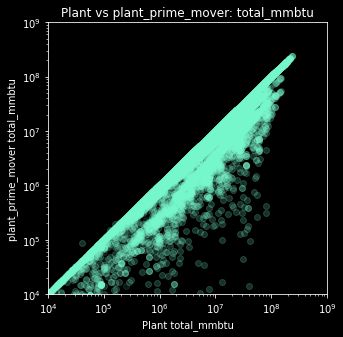

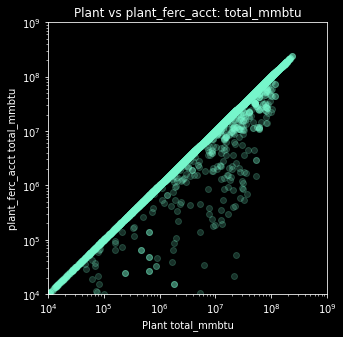

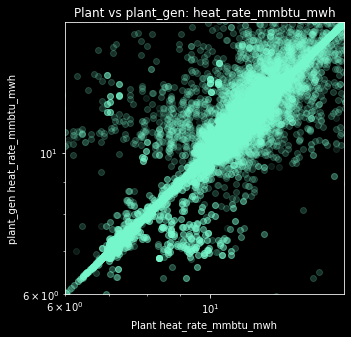

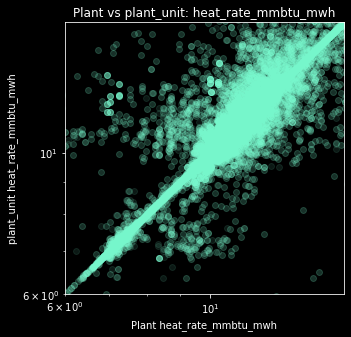

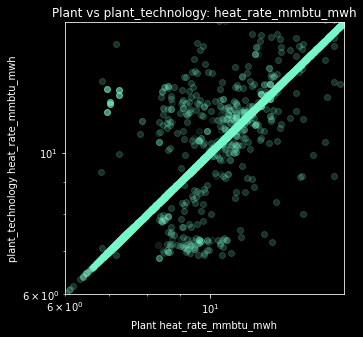

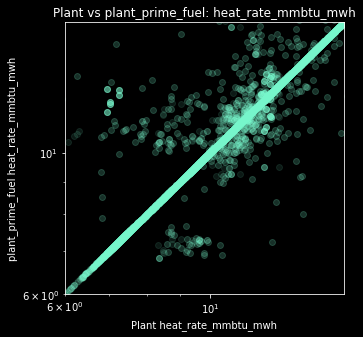

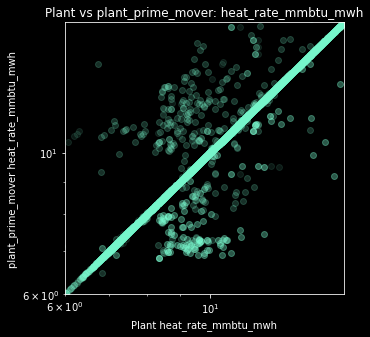

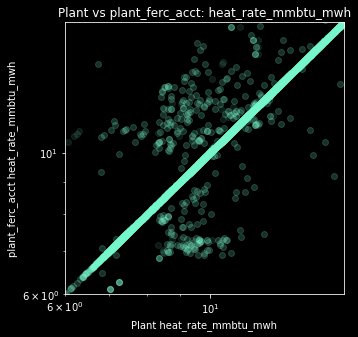

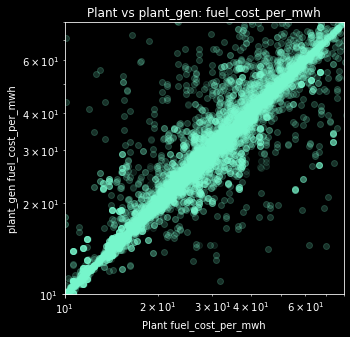

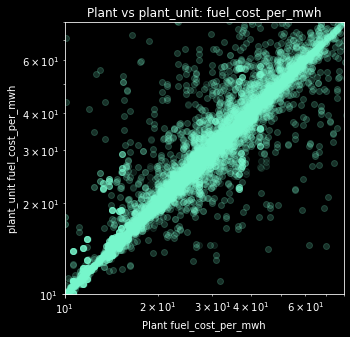

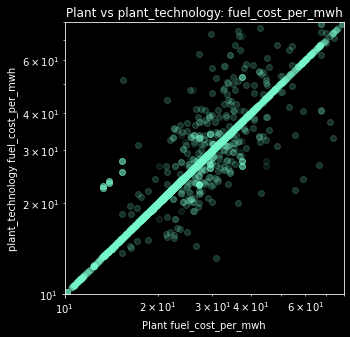

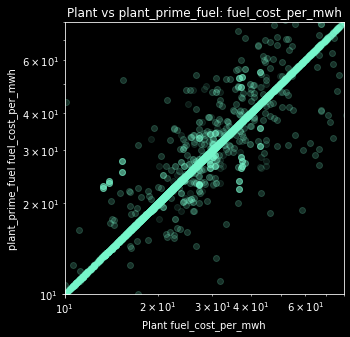

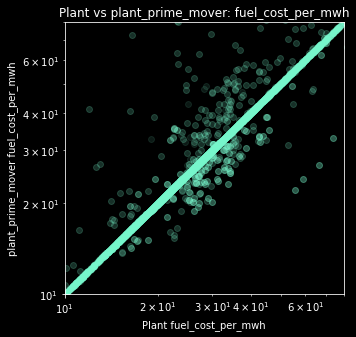

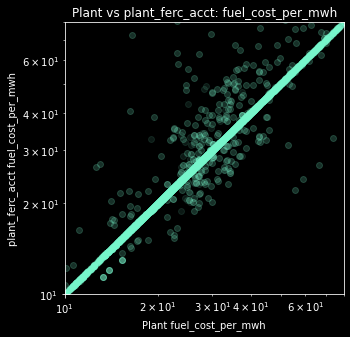

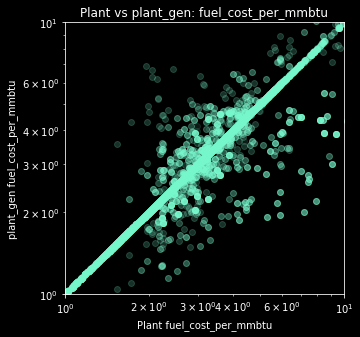

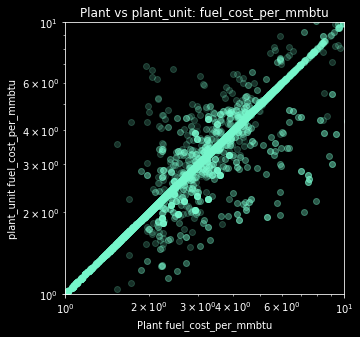

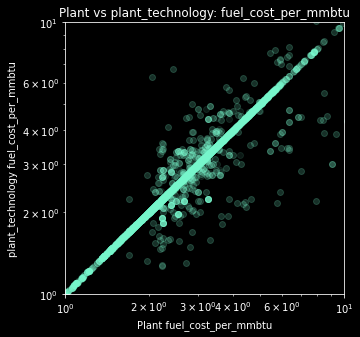

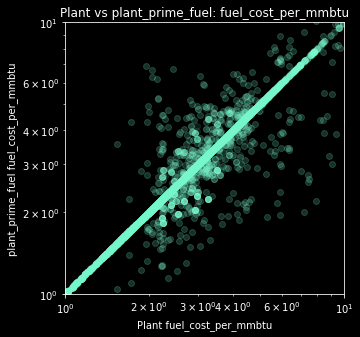

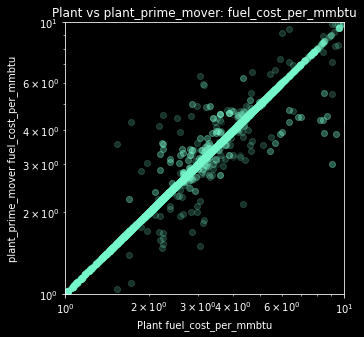

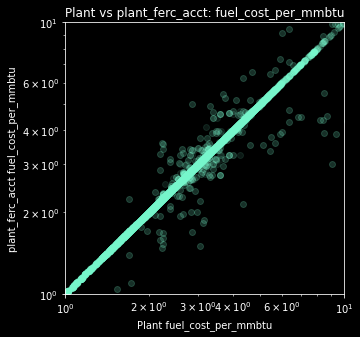

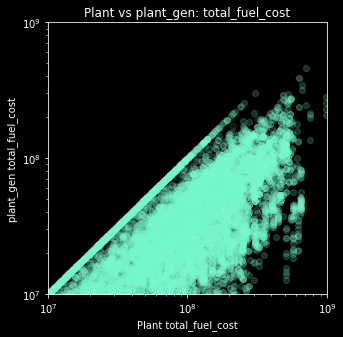

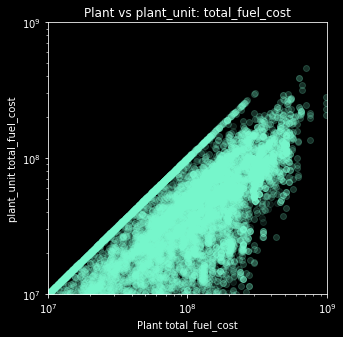

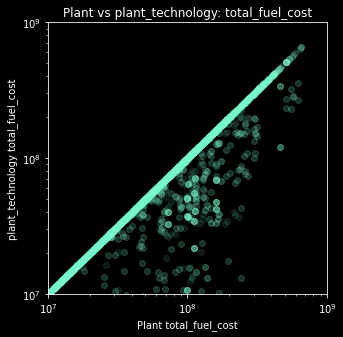

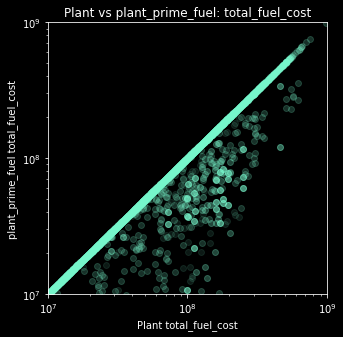

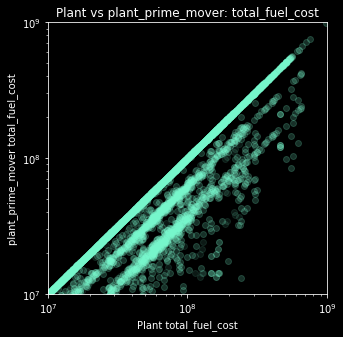

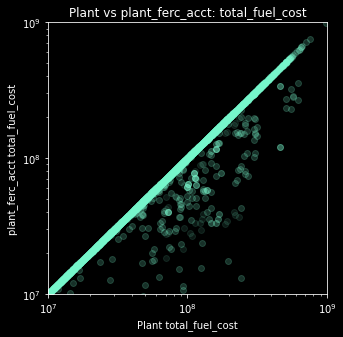

In [15]:
fields_to_plot = [
    # Simple Quantities
    'capacity_mw',
    'net_generation_mwh',
    'total_mmbtu',
    # Derived values
    #'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh',
    'fuel_cost_per_mmbtu',
    'total_fuel_cost'
]

xy_limits = {
    # Simple Quantities
    'capacity_mw': (1e0, 1e4),
    'net_generation_mwh': (1e3,1e8),
    'total_mmbtu': (1e4,1e9),
    # Derived values
    'capacity_factor': (0,1.0),
    'heat_rate_mmbtu_mwh': (6,16),
    'fuel_cost_per_mwh': (10,80),
    'fuel_cost_per_mmbtu': (1e0,1e1),
    'total_fuel_cost': (1e7,1e9)
}

for field in fields_to_plot:
    plot_plant_vs_agg(compiled_plant_parts,field, xy_limits, scale="log")

In [16]:
def plot_gens_vs(compiled_plant_parts,part_name, data_col, weight_col, x_range):
    gen_df = compiled_plant_parts['plant_gen'][compiled_plant_parts['plant_gen'][data_col] != 0]
    part_df = compiled_plant_parts[part_name][compiled_plant_parts[part_name][data_col] != 0]
    if weight_col:
        weights_gen = gen_df[weight_col]
        weights_part = part_df[weight_col]
    else:
        weights_gen = None
        weights_part = None

    plt.hist(gen_df[data_col], 
             weights=weights_gen,
             range=x_range,
             bins=100,
             color="purple", #alpha=test_alpha,
             label="Generators")

    plt.hist(part_df[data_col], 
             weights=weights_part,
             range=x_range,
             bins=100,
             color="aquamarine",
             label=f'{part_name}')

    plt.title(f'Gens vs. {part_name}: {data_col}')
    plt.xlabel(data_col)
    plt.ylabel(None)
    plt.legend()
    plt.show()

In [17]:
x_ranges = {
    'capacity_mw' : (0,400),
    'net_generation_mwh': (0, 2500000),
    'fuel_cost_per_mmbtu': (0, 5),
    'fuel_cost_per_mwh': (0, 100),
    'total_fuel_cost': (0,200000000)
}

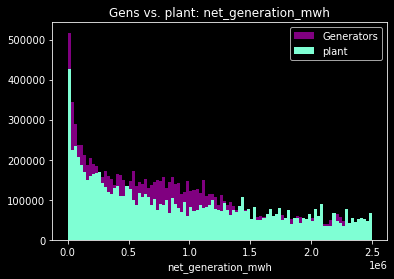

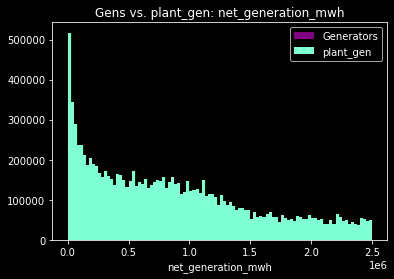

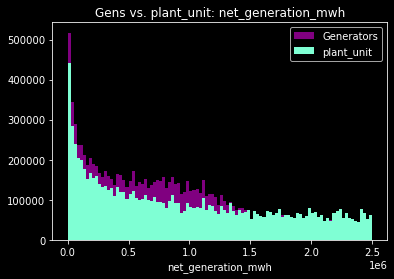

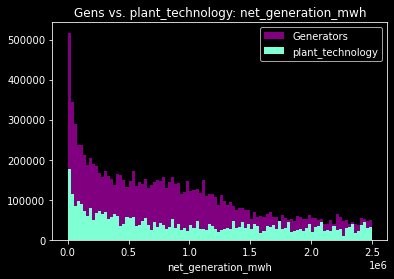

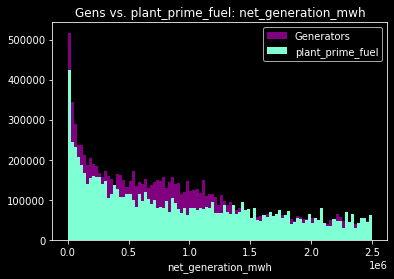

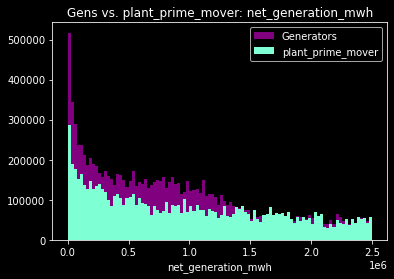

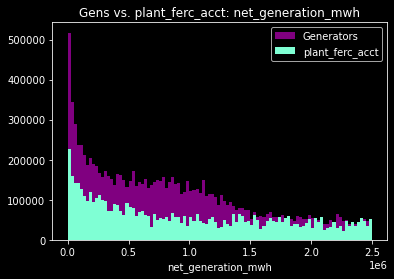

In [18]:
for part_name in compiled_plant_parts.keys():
    data_col =  'net_generation_mwh'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

In [ ]:
for part_name in compiled_plant_parts.keys():
    data_col =  'total_fuel_cost'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

In [ ]:
for part_name in compiled_plant_parts.keys():
    data_col =  'fuel_cost_per_mwh'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

In [ ]:
for part_name in compiled_plant_parts.keys():
    data_col =  'fuel_cost_per_mmbtu'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

## Playing with the compiled outputs 

In [ ]:
null_zeros = {0:np.NaN}
count_df = pd.DataFrame(index=list(compiled_plant_parts['plant'].columns))
for k,cpp_df in compiled_plant_parts.items():
    cpp_df = cpp_df.replace({
        'net_generation_mwh':null_zeros,
        'capacity_factor' : null_zeros,
        'fuel_cost_per_mmbtu': null_zeros,
        'fuel_cost_per_mwh': null_zeros,
        'capacity_mw': null_zeros,
                        })
    count_df = count_df.merge(
        pd.DataFrame(cpp_df[cpp_df['report_date'].dt.year == 2018]
                     .count(), columns=[k]),
        right_index=True, left_index=True)
count_df = count_df.merge(pd.DataFrame(count_df.sum(axis=1),columns=['total']),
                          right_index=True, left_index=True)
count_df